# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Download the data

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
from glob import glob

In [69]:
import os
from dataclasses import dataclass
from glob import glob

import numpy as np
import pandas as pd
import tensorflow as tf


def get_basename_no_ext(inp):
    return os.path.splitext(os.path.basename(inp[0]))[0]


def get_basenames_no_ext_arr(arr):
    arr_base = np.array(arr).reshape(-1,1)
    arr_base = [os.path.splitext(os.path.basename(inp[0]))[0] for inp in arr_base]
#     arr_base = np.apply_along_axis(get_basename_no_ext, 1, arr_base)
    return arr_base


def check_existance(img_name, true_labels_paths):
#     true_labels_paths = glob(os.path.join(inp_path, "*"))
    true_labels_paths_base = get_basenames_no_ext_arr(true_labels_paths)
    img_name_no_ext = os.path.splitext(os.path.basename(img_name))[0]
    if img_name_no_ext in true_labels_paths_base:
        return 1
    else:
        return 0


@dataclass
class Data:
    image: str
    label: str
    mask: str=""


def get_df(images_path, labels_path):
    img_paths = glob(os.path.join(images_path, "*"))
    label_paths = glob(os.path.join(labels_path, "*"))

    rows = []
    for i, img_path in enumerate(img_paths):
        img_class = check_existance(img_path, label_paths)
        rows.append([img_path, img_class, 0])
    return np.array(rows)

def get_df_acc(images_path, labels_path, masks_path):
    img_paths = glob(os.path.join(images_path, "*"))
    mask_paths = [os.path.join(masks_path, f"mask{os.path.splitext(os.path.basename(img_path))[0][3:]}.jpg") for img_path in img_paths]
    zeros = np.ones(len(img_paths))
    rows = np.concatenate((np.array(img_paths).reshape(-1, 1), zeros.reshape(-1, 1),
                           np.array(mask_paths).reshape(-1, 1)), axis=1)
    return rows

def get_df_real(images_path, masks_path):
    img_paths = glob(os.path.join(images_path, "*"))
    mask_paths = [os.path.join(masks_path, f"{os.path.splitext(os.path.basename(img_path))[0]}.png") for img_path in img_paths]
    zeros = np.ones(len(img_paths))
    rows = np.concatenate((np.array(img_paths).reshape(-1, 1), zeros.reshape(-1, 1),
                           np.array(mask_paths).reshape(-1, 1)), axis=1)
    return rows

def append_images(img_path, req_size):
    img_paths = glob(os.path.join(img_path, "*"))
    dir_size = len(img_paths)
    print(dir_size)
    if dir_size < req_size:
        print("len is less than req_size, appending...")
        for i in range(req_size // dir_size + 1):
            img_paths = img_paths + img_paths
        img_paths = img_paths[:req_size]
    else:
        img_paths = img_paths[:req_size]
    zeros = np.zeros(req_size)
    rows = np.concatenate((np.array(img_paths).reshape(-1, 1), zeros.reshape(-1, 1),
                           zeros.reshape(-1, 1)), axis=1)
    return rows

In [70]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [116]:
train_data = Data("/home/ubuntu/workspace/create_train_set/data/dataset_out_mask/images/train",
                  "/home/ubuntu/workspace/create_train_set/data/dataset_out_mask/labels/train",
                  "/home/ubuntu/workspace/create_train_set/data/dataset_out_mask/masks/train")
rows_label_1 = get_df_acc(train_data.image, train_data.label, train_data.mask)
img_path_label_0 = "/home/ubuntu/workspace/datasets/architecture_and_3d-printers_bw"
rows_label_0 = append_images(img_path_label_0, rows_label_1.shape[0])
rows = np.concatenate((rows_label_0, rows_label_1))
df_train = pd.DataFrame(rows_label_1, columns=['filename', 'label', 'mask_'])
df_train.label = df_train.label.astype("float").astype("int8")
# print(df_train.info())
# print(len(df_train[df_train.label == 0]))
# print(len(df_train[df_train.label == 1]))

val_data = Data("/home/ubuntu/workspace/create_train_set/data/dataset_out_mask/images/val",
                  "/home/ubuntu/workspace/create_train_set/data/dataset_out_mask/labels/val",
                "/home/ubuntu/workspace/create_train_set/data/dataset_out_mask/masks/val")
rows_label_1 = get_df_acc(val_data.image, val_data.label, val_data.mask)
img_path_label_0 = "/home/ubuntu/workspace/datasets/architecture_and_3d-printers_bw"
rows_label_0 = append_images(img_path_label_0, rows_label_1.shape[0])
rows = np.concatenate((rows_label_0, rows_label_1))
df_val = pd.DataFrame(rows_label_1, columns=['filename', 'label', 'mask_'])
df_val.label = df_val.label.astype("float").astype("int8")

test_data = Data("/home/ubuntu/workspace/create_train_set/data/rgb_images_spag_&_bckg_bw",
                "/home/ubuntu/workspace/create_train_set/data/yolo-labels/")
rows = get_df(test_data.image, test_data.label)
df_test = pd.DataFrame(rows, columns=['filename', 'label', 'mask_'])
df_test.label = df_test.label.astype("float").astype("int8")

7293
7293


In [79]:
df_test.label

0      1
1      1
2      1
3      1
4      0
      ..
143    0
144    0
145    1
146    0
147    0
Name: label, Length: 148, dtype: int8

## Prepare paths of input images and target segmentation masks

In [5]:
tf.config.list_physical_devices('GPU')
tf.__version__
import sys
sys.version

'3.8.13 (default, Mar 28 2022, 11:38:47) \n[GCC 7.5.0]'

In [6]:
import os

img_size = (720, 720)
num_classes = 2
batch_size = 32

input_img_paths = df_train.filename.to_list()
target_img_paths = df_train.mask_.astype(str).to_list()

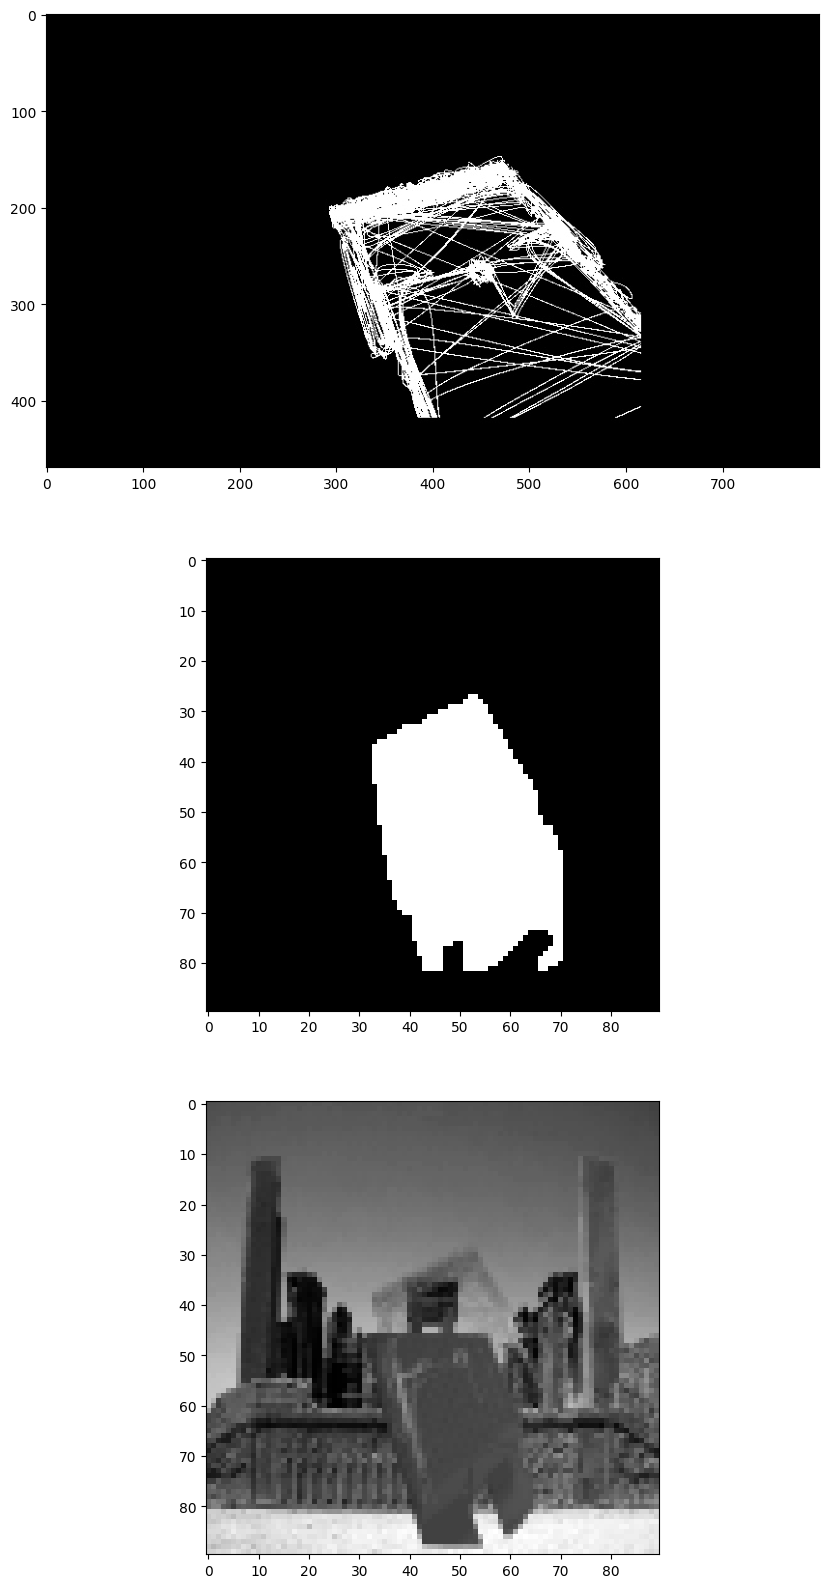

In [7]:
import imgaug.augmenters as iaa

# process mask
def resize_mask(mask, target_shape):
    kernel = np.ones((15, 15), np.uint8)
    mask =  cv.morphologyEx(mask, cv.MORPH_DILATE, kernel)
    mask =  cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
    shape = (target_shape[1], target_shape[0])
    mask = cv.resize(mask, shape, interpolation=cv.INTER_NEAREST) #cv.INTER_AREA
    return mask

def img_to_binary(mask):
    mask[mask<=125] = 0
    mask[mask>125] = 1
    return mask

def load_img_cv(path, target_size, is_mask=False, augment=True):
    if not is_mask:
        img = cv.imread(path, cv.IMREAD_GRAYSCALE)
        shape = (target_size[1], target_size[0])
        img = cv.resize(img, shape, interpolation=cv.INTER_AREA)
        if augment:
            aug = iaa.GammaContrast((0.5, 3.0))
            img = aug(image=img)
    else:
        img = cv.imread(path, cv.IMREAD_GRAYSCALE)
        img[img<=30] = 0
        img[img>30] = 255
        img = resize_mask(img, target_size)
        img = img_to_binary(img)
    return img

mask = cv.imread(target_img_paths[15], cv.IMREAD_GRAYSCALE)
target_size = (90, 90)
# print(mask.shape)
# kernel = np.ones((10, 10), np.uint8)
# mask =  cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
# img = cv.erode(img, kernel, iterations=1)
# img = cv.dilate(img, kernel, iterations=1)
mask_new = load_img_cv(target_img_paths[15], target_size, is_mask=True)
img = load_img_cv(input_img_paths[15], target_size, is_mask=False)
fig, ax = plt.subplots(3,1,figsize=(25,20))
ax[0].imshow(mask, cmap="gray")
ax[1].imshow(mask_new, cmap="gray")
ax[2].imshow(img, cmap="gray")

## What does one input image and corresponding segmentation mask look like?

In [22]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import numpy as np

# # Display input image #7
# display(Image(filename=input_img_paths[9]))

# # Display auto-contrast version of corresponding target (per-pixel categories)
# img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
# display(img)

# img = cv.imread(input_img_paths[9])
# mask = cv.imread(target_img_paths[9])
# mask = (mask - np.amin(mask)) / np.amax(mask - np.amin(mask))
data = train_gen
img = data[1][0][0][:,:,0]
mask = data[1][1][0][:,:,0]
fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].imshow(img)
ax[1].imshow(mask)

NameError: name 'train_gen' is not defined

In [ ]:
len(train_gen[1][0])

## Prepare `Sequence` class to load & vectorize batches of data

In [8]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

    
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, target_size, input_img_paths, target_img_paths, augment=True):
        self.batch_size = batch_size
        self.img_size = img_size
        self.target_size = target_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.augment = augment

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img_cv(path, target_size=self.img_size, augment=self.augment)
            x[j] = np.expand_dims(img, 2)
        y = np.zeros((self.batch_size,) + self.target_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img_cv(path, target_size=self.target_size, is_mask=True)
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
#             y[j] -= 1
        return x, y

class OxfordPets2(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, target_size, input_img_paths, target_img_paths, augment=True):
        self.batch_size = batch_size
        self.img_size = img_size
        self.target_size = target_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.augment = augment

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        y = np.zeros((self.batch_size,) + self.target_size + (1,), dtype="uint8")
        for i, paths in enumerate(zip(batch_input_img_paths, batch_target_img_paths)):
            path_input, path_target = paths
            img, mask = load_data(path_input, path_target)
            img = preprop_img(img, self.img_size)
            mask = preprop_mask(mask, self.target_size)
            x[i] = np.expand_dims(img, 2)
            y[i] = np.expand_dims(mask, 2)
        return x, y

## Prepare U-Net Xception-style model

In [24]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
#     x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128]: #, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
# model.summary()

2022-10-31 16:39:37.148176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:39:37.150025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:39:37.151552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:39:37.153138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:39:37.154658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [25]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
#     x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [32, 64]: #, 64]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128]: #, 128]: #, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
# model.summary()

In [9]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [32, 64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128]: #, 128]: #, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
    
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
# model.summary()

2022-10-31 16:51:27.711048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 16:51:27.711535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:51:27.714975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:51:27.717541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

In [11]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 720, 720, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 360, 360, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 360, 360, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

 max_pooling2d_2 (MaxPooling2D)  (None, 45, 45, 128)  0          ['batch_normalization_6[0][0]']  
                                                                                                  
 conv2d_3 (Conv2D)              (None, 45, 45, 128)  8320        ['add_1[0][0]']                  
                                                                                                  
 add_2 (Add)                    (None, 45, 45, 128)  0           ['max_pooling2d_2[0][0]',        
                                                                  'conv2d_3[0][0]']               
                                                                                                  
 activation_7 (Activation)      (None, 45, 45, 128)  0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 45, 45, 128)  147584     ['activation_7[0][0]']           
 ose)     

In [293]:
from tensorflow.keras.models import load_model

# Load the previously saved weights
model = load_model("oxford_segmentation.h5")

In [28]:
len(df_train)

7268

In [12]:
df_train = df_train.iloc[0:4000]
while (len(df_train)<5000):
    df_train = pd.concat([df_train,df_real])

In [13]:
df_val = df_val.iloc[0:1000]

## Set aside a validation split

In [14]:
import random

# Split our img paths into a training and a validation set
# val_samples = 1000
# random.Random(1337).shuffle(input_img_paths)
# random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = df_train.filename.to_list()
train_target_img_paths = df_train.mask_.astype(str).to_list()
val_input_img_paths = df_val.filename.to_list()
val_target_img_paths = df_val.mask_.astype(str).to_list()

# Instantiate data Sequences for each split
train_gen = OxfordPets2(
    batch_size, img_size, target_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets2(batch_size, img_size, target_size, val_input_img_paths, val_target_img_paths)

In [38]:
train_gen[1]

(array([[[[ 23],
          [ 23],
          [ 23],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[ 23],
          [ 23],
          [ 23],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[ 23],
          [ 23],
          [ 23],
          ...,
          [  0],
          [  0],
          [  0]],
 
         ...,
 
         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]]],
 
 
        [[[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[  0],
    

## Train the model

In [17]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 3
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks,
                   max_queue_size=15)

Epoch 1/3
157/157 [==============================] - 311s 2s/step - loss: 0.2261 - val_loss: 0.4301
Epoch 2/3
157/157 [==============================] - 307s 2s/step - loss: 0.2088 - val_loss: 0.3868
Epoch 3/3
157/157 [==============================] - 305s 2s/step - loss: 0.1969 - val_loss: 0.2878


In [18]:
def get_mask(i, preds, scale=False):
    """Quick utility to display a model's prediction."""
    if not scale:
        mask = np.argmax(val_preds[i], axis=-1)
    else:
        mask = preds[i][:, :, 1] 
    
#     mask = np.expand_dims(mask, axis=-1)
#     img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
#     display(img)
    return mask

In [125]:
!pwd

/home/ubuntu/workspace/classifiers


In [124]:
model.save('seg_model/seg_only_sim.h5')

## Visualize predictions

31/31 [==============================] - 14s 433ms/step
(90, 90)


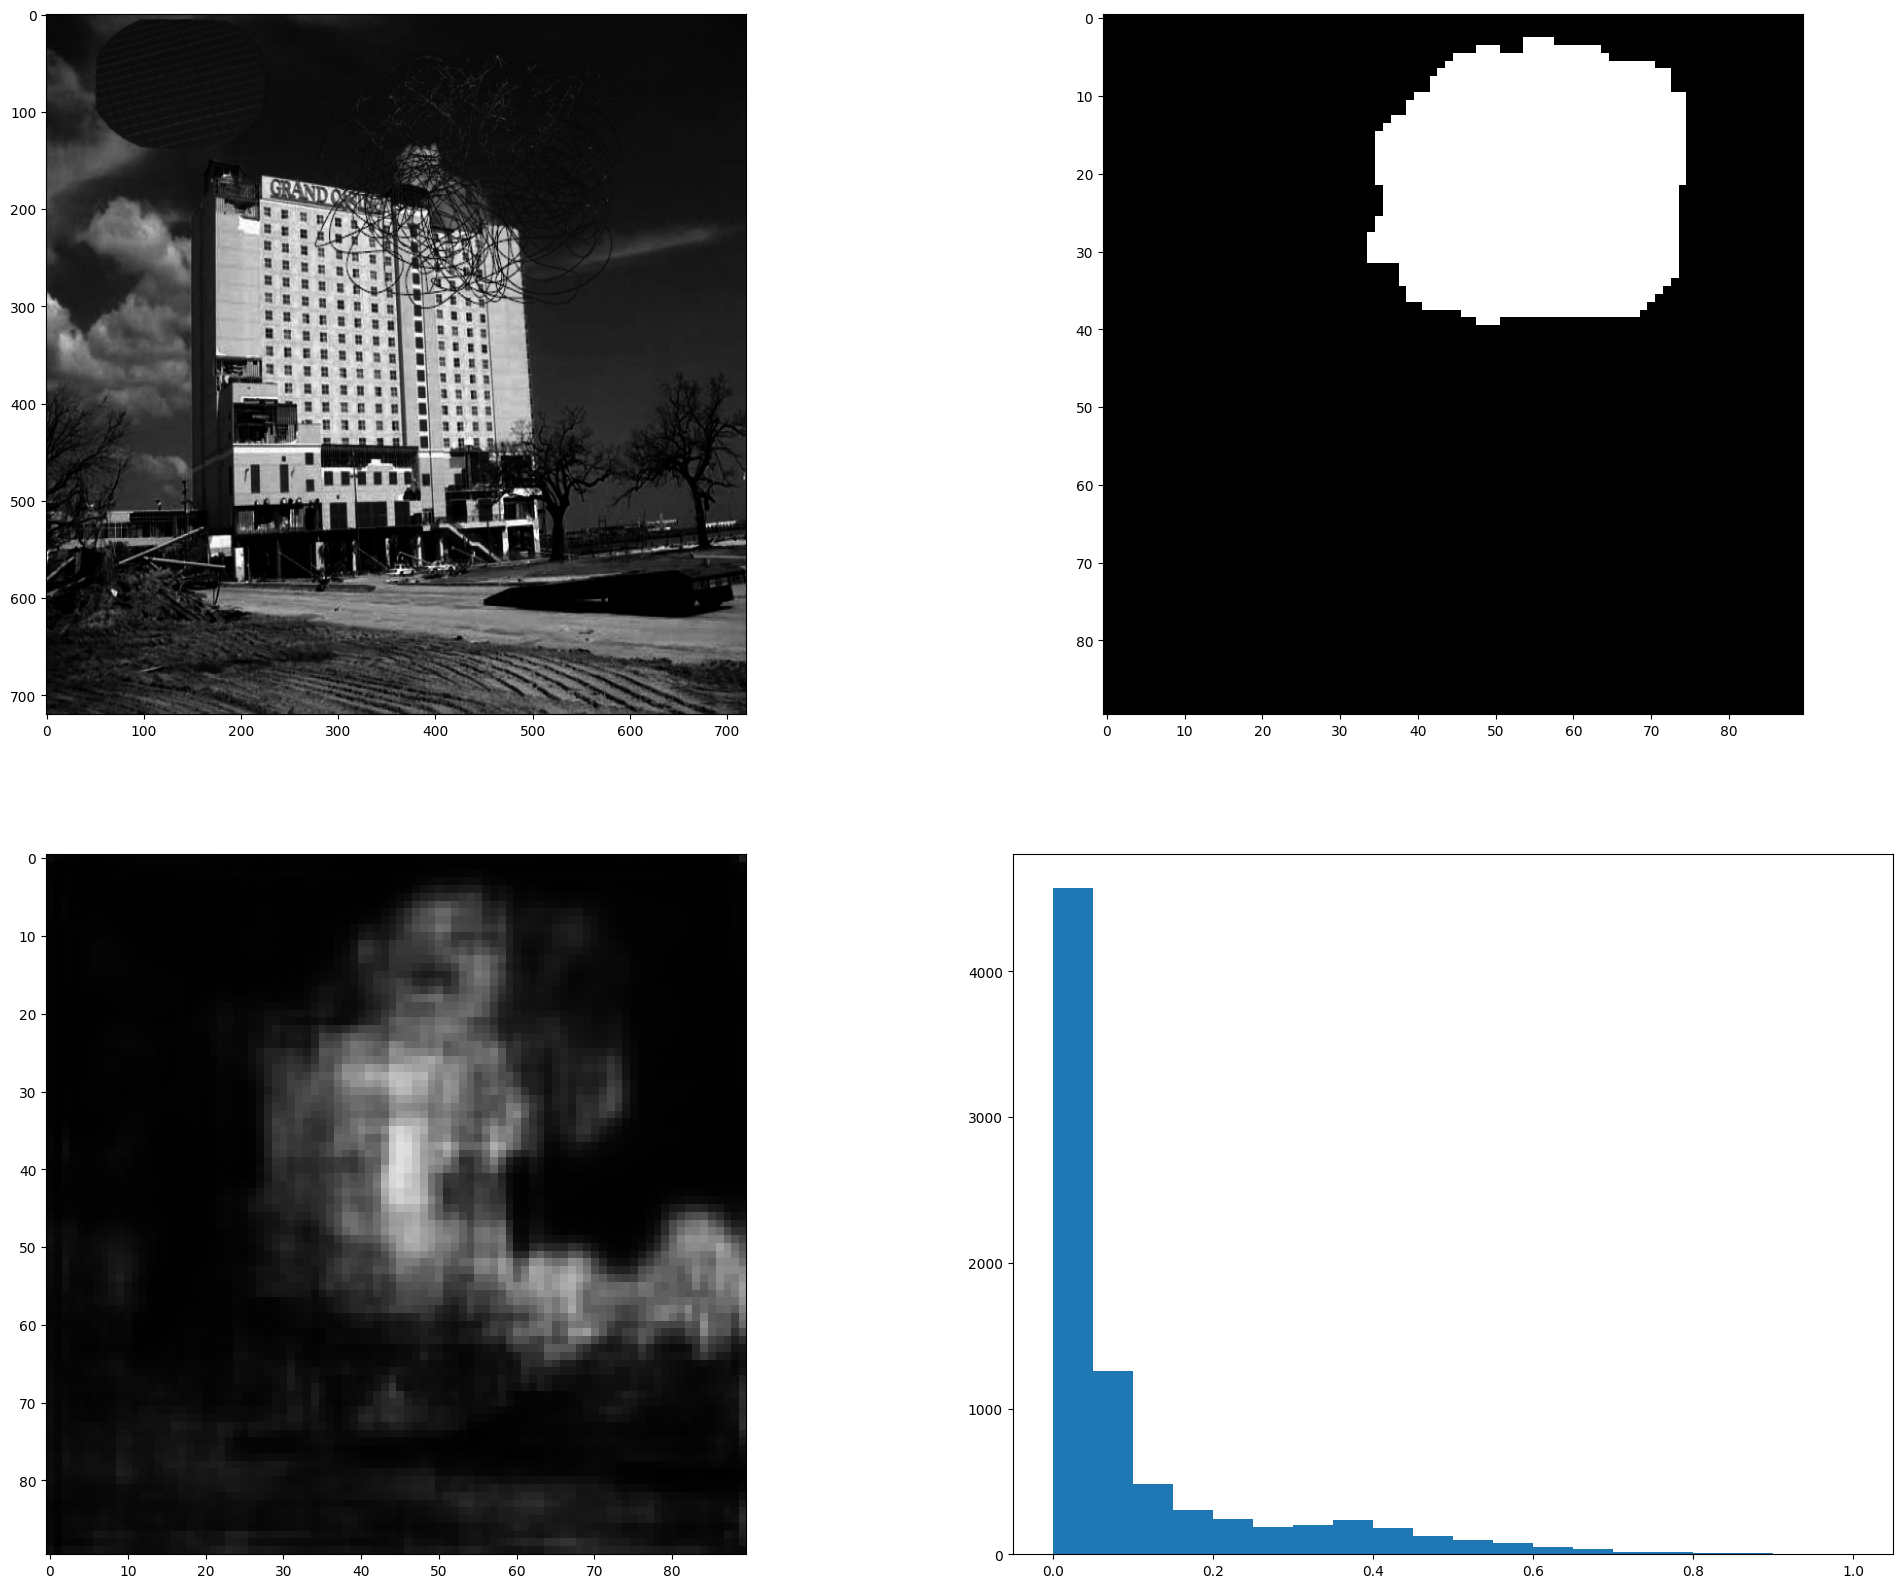

In [19]:
from matplotlib.colors import Normalize
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, target_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


# Display results for validation image #10
i = 1

img = load_img_cv(val_input_img_paths[i], img_size, is_mask=False)
mask = load_img_cv(val_target_img_paths[i], target_size, is_mask=True)
fig, ax = plt.subplots(2,2,figsize=(25,20))
ax[0, 0].imshow(img, cmap="gray")
ax[0, 1].imshow(mask, cmap="gray")

mask_pred = get_mask(i, val_preds, scale=True)
print(mask_pred.shape)
ax[1, 0].imshow(mask_pred.reshape(mask_pred.shape[:2]), cmap="gray", vmin=0, vmax=1.0)#, norm=Normalize([0, 1]))
ax[1, 1].hist(mask_pred.reshape(-1), bins=20, range=[0, 1]);
# Display input image
# display(Image(filename=val_input_img_paths[i]))

# # Display ground-truth target mask
# img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
# display(img)

# # Display mask predicted by our model
# display_mask(i)  # Note that the model only sees inputs at 150x150.

In [467]:
# custom loss check
# val_gen = OxfordPets(batch_size, img_size, target_size, val_input_img_paths[:32], val_target_img_paths[:32])
eval_res = model.evaluate(val_gen, batch_size=batch_size)
val_preds = model.predict(val_gen)
losses = []
for i, target_path in enumerate(val_target_img_paths[:32]):
    mask_val_gt = load_img_cv(target_path, target_size=target_size, is_mask=True)
    mask_val_pred = val_preds[i]
    sum_ = np.sum([np.sum(np.log(mask_val_pred[mask_val_gt == label, label])) for label in [0, 1]])
    losses.append(sum_ / np.product(target_size))
print(f"tf eval loss: {eval_res}, manual calc loss {np.mean(losses)}")

90/90 [==============================] - 23s 260ms/step - loss: 0.6644
tf eval loss: 0.664387047290802, manual calc loss -0.8530747536082328


In [ ]:
# time check - cv2 is faster than tf load_img()
from time import time
start = time()
for i in range(10):
#     img1 = load_img_cv(val_input_img_paths[0], target_size=img_size)
    img2 = load_img(val_input_img_paths[0], target_size=img_size,
                        interpolation='bilinear')
end = time()
print('time passed', end - start)

In [20]:
# test run
test_input_img_paths = df_test.filename.to_list()
# val_target_img_paths = df_test.mask_.astype(str).to_list()

# Instantiate data Sequences for each split
test_gen = OxfordPets(batch_size, img_size, target_size, test_input_img_paths, val_target_img_paths[:152], 
                      augment=False)
test_preds = model.predict(test_gen)

4/4 [==============================] - 3s 631ms/step


In [223]:
i = -1

In [441]:
i = 1

In [21]:
def visualize_mask(image, mask, coeff=0.5):
    shape = image.shape[:2]
    mask = cv.resize(mask, shape, interpolation=cv.INTER_AREA) * coeff
    image = image.astype(np.float32)
    image = (image * (1 - mask)).astype(np.uint8)
    mask = np.clip(mask*255, a_min=0, a_max=255).astype(np.uint8)
    image = np.array([image,image,image]).transpose(1,2,0)
    color_mask = np.array([mask, np.zeros(shape), np.zeros(shape)]).transpose(1,2,0).astype(np.uint8)
    image = image + color_mask
    return image

(90, 90)
(720, 720, 3)


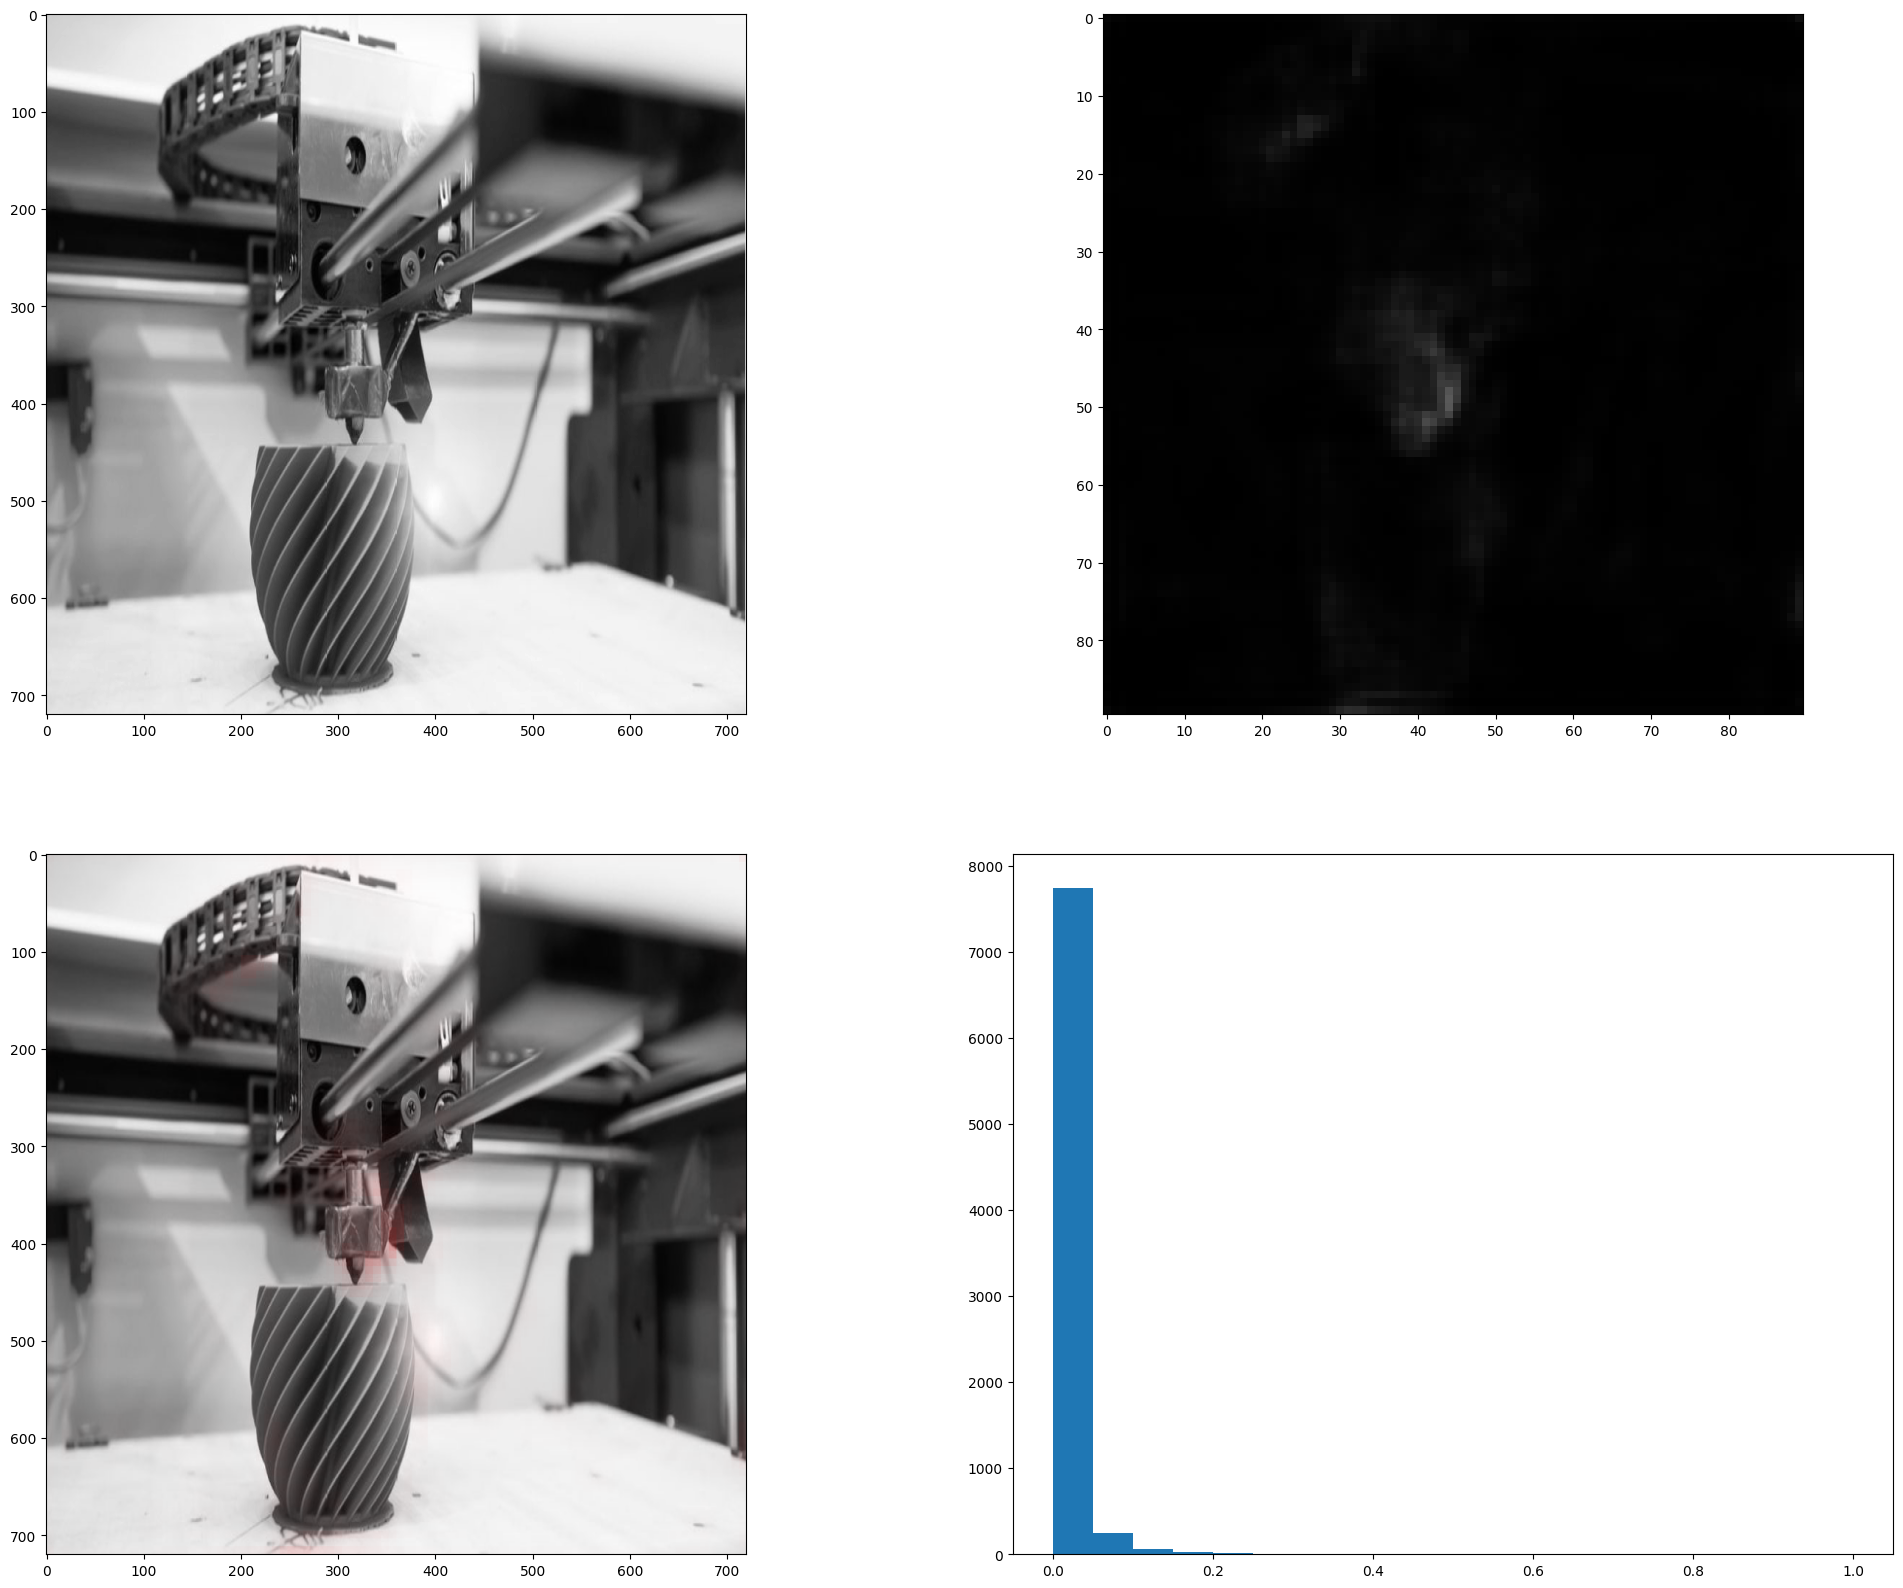

<Figure size 800x800 with 0 Axes>

In [36]:
# Display results for validation image 
i += 1

img = load_img_cv(test_input_img_paths[i], img_size, is_mask=False, augment=False)
mask_pred = get_mask(i, test_preds, scale=True)
print(mask_pred.shape)

img_pred = visualize_mask(img, mask_pred, coeff=0.7)
print(img_pred.shape)
fig, ax = plt.subplots(2,2,figsize=(25,20))
my_dpi = 90
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
ax[0, 0].imshow(img, cmap="gray")
ax[0, 1].imshow(mask_pred.reshape(mask_pred.shape[:2]), vmin=0, vmax=1.0, cmap="gray")
ax[1, 0].imshow(img_pred, vmin=0, vmax=255.0)
ax[1, 1].hist(mask_pred.reshape(-1), bins=20, range=[0, 1]);

In [24]:
plt.savefig("four.png", dpi=1000)

<Figure size 640x480 with 0 Axes>

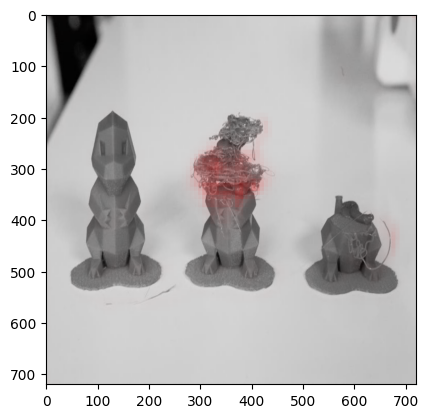

In [33]:
plt.imshow(img_pred, vmin=0, vmax=255.0)
plt.savefig("1.png")

## real images train

In [11]:
real_imgs = "/home/ubuntu/workspace/datasets/raise-labeled/real_spag_raise/"
real_masks = "/home/ubuntu/workspace/datasets/raise-labeled/real_spag_raise_masks/"
real_data = Data(real_imgs,
                "",
               real_masks)
rows = get_df_real(real_data.image, real_data.mask)
df_real = pd.DataFrame(rows, columns=['filename', 'label', 'mask_'])
df_real.label = df_real.label.astype("float").astype("int8")

In [30]:
df_real

,filename,label,mask_
0,/home/ubuntu/workspace/datasets/raise-labeled/...,1,/home/ubuntu/workspace/datasets/raise-labeled/...
1,/home/ubuntu/workspace/datasets/raise-labeled/...,1,/home/ubuntu/workspace/datasets/raise-labeled/...
2,/home/ubuntu/workspace/datasets/raise-labeled/...,1,/home/ubuntu/workspace/datasets/raise-labeled/...
3,/home/ubuntu/workspace/datasets/raise-labeled/...,1,/home/ubuntu/workspace/datasets/raise-labeled/...
4,/home/ubuntu/workspace/datasets/raise-labeled/...,1,/home/ubuntu/workspace/datasets/raise-labeled/...
...,...,...,...
56,/home/ubuntu/workspace/datasets/raise-labeled/...,1,/home/ubuntu/workspace/datasets/raise-labeled/...
57,/home/ubuntu/workspace/datasets/raise-labeled/...,1,/home/ubuntu/workspace/datasets/raise-labeled/...
58,/home/ubuntu/workspace/datasets/raise-labeled/...,1,/home/ubuntu/workspace/datasets/raise-labeled/...
59,/home/ubuntu/workspace/datasets/raise-labeled/...,1,/home/ubuntu/workspace/datasets/raise-labeled/...


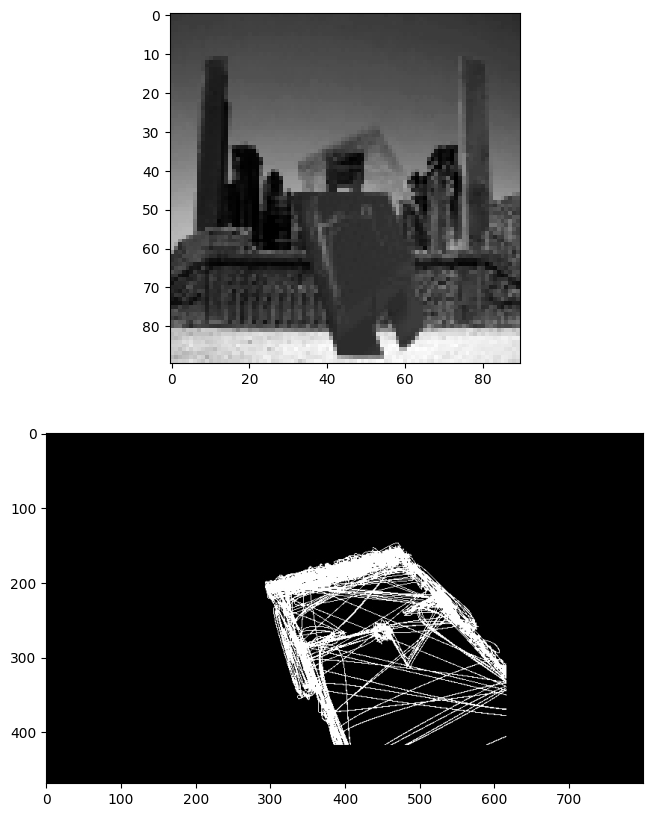

In [31]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].imshow(img, cmap="gray")
ax[1].imshow(mask, cmap="gray")

In [10]:
def img_to_binary(mask):
    mask[mask<=125] = 0
    mask[mask>125] = 1
    return mask

from imgaug.augmentables.segmaps import SegmentationMapsOnImage

seq = iaa.Sequential([
    iaa.Affine(rotate=(-45, 45), scale=(1.0,1.6),translate_percent=(-0.2,0.2)),  # rotate by -45 to 45 degrees (affects segmaps)
    #iaa.ElasticTransformation(alpha=50, sigma=5)  # apply water effect (affects segmaps)
    iaa.GammaContrast((0.3, 2.0))
], random_order=True)

def preprop_img(img, target_size):
    shape = (target_size[1], target_size[0])
    img = cv.resize(img, shape, interpolation=cv.INTER_AREA)
    return img

def preprop_mask(mask, target_size):
    shape = (target_size[1], target_size[0])
    mask = cv.resize(mask, shape, interpolation=cv.INTER_NEAREST)
    mask = img_to_binary(mask)
    return mask
    
def augment(img, mask, seq, shape):
    mask = SegmentationMapsOnImage(mask, shape=shape)
    img, mask = seq(image=img, segmentation_maps=mask)
    return img, mask.get_arr()
    
def load_data(inp_path, target_path, shape=(1000, 1000)):
    img = cv.imread(inp_path, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, shape, interpolation=cv.INTER_AREA)
    mask = cv.imread(target_path, cv.IMREAD_GRAYSCALE)
    kernel = np.ones((15, 15), np.uint8)
    mask =  cv.morphologyEx(mask, cv.MORPH_DILATE, kernel)
    mask =  cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
    mask = cv.resize(mask, shape, interpolation=cv.INTER_NEAREST)
    mask[mask<=30] = 0
    mask[mask>30] = 255
    img, mask = augment(img, mask, seq, shape)
    return img, mask

In [415]:
i=2
img_path = df_real.iloc[i].filename
mask_path = df_real.iloc[i].mask_
img, mask = load_data(img_path, mask_path)
img = preprop_img(img, (700, 700))
mask = preprop_mask(mask, (100, 100))

In [362]:
img.shape

(1000, 1000)

In [435]:
real_input_img_paths = df_real.filename.to_list()
real_target_img_paths = df_real.mask_.astype(str).to_list()
batch_size=20
# Instantiate data Sequences for each split
real_gen = OxfordPets2(
    batch_size, img_size, target_size, real_input_img_paths, real_target_img_paths
)

In [ ]:
epochs = 20
history = model.fit(real_gen, epochs=epochs, validation_data=real_gen, callbacks=callbacks,
                   max_queue_size=15)

## get acc metrics

In [120]:
df_test.label.value_counts()

1    113
0     56
Name: label, dtype: int64

In [119]:
# add all 1
test_data2 = Data("/home/ubuntu/workspace/create_train_set/data/spaghetti_bw",
                "/home/ubuntu/workspace/create_train_set/data/spaghetti_bw")
rows = get_df(test_data2.image, test_data2.label)
df_test2 = pd.DataFrame(rows, columns=['filename', 'label', 'mask_'])
df_test2.label = df_test2.label.astype("float").astype("int8")
df_test = pd.concat([df_test,df_test2])

In [121]:
# test run
test_input_img_paths = df_test.filename.to_list()
# val_target_img_paths = df_test.mask_.astype(str).to_list()

# Instantiate data Sequences for each split
test_gen = OxfordPets2(1, img_size, target_size, test_input_img_paths, val_target_img_paths[:len(test_input_img_paths)], 
                      augment=False)
test_preds = model.predict(test_gen)

169/169 [==============================] - 6s 35ms/step


In [115]:
df_test.label.value_counts()

1    134
0     56
Name: label, dtype: int64

In [122]:
test_preds.shape

(169, 90, 90, 2)

In [123]:
thresh = 0.4
thresh_num_pxls = 30
final_preds = []
for i in range(len(test_preds)):
    pred_i = test_preds[i,:,:,1]
    counts = pred_i > thresh
    counts = np.count_nonzero(counts)
    final_pred = 1 if counts > thresh_num_pxls else 0
    final_preds.append(final_pred)

from sklearn.metrics import confusion_matrix, precision_score, recall_score

conf_mat = confusion_matrix(df_test.label, final_preds)
prec = precision_score(df_test.label, final_preds)
rec = recall_score(df_test.label, final_preds)
print(prec, rec)
print(conf_mat)

0.9264705882352942 0.5575221238938053
[[51  5]
 [50 63]]


In [167]:
## yolo test
imgs_out_path = "/home/ubuntu/workspace/AWS_server/test_data/im_out_keras/"
imgs_out_paths = glob(os.path.join(imgs_out_path, "*"))
im_name_to_conf = {}
for im_path in imgs_out_paths:
    base_name = os.path.basename(im_path)
    im_name, conf, _ = base_name.split('_')[-3:]
    name_real = "_".join(base_name.split('_')[:-2])
    im_name_to_conf[name_real] = float(conf)

In [168]:
yolo_thresh = 0.07
yolo_test_res = []
for inp_path in test_input_img_paths:
    base = os.path.basename(inp_path)
    conf = im_name_to_conf[base]
    conf_res = 1 if conf > yolo_thresh else 0
    yolo_test_res.append(conf_res)

In [169]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

conf_mat = confusion_matrix(df_test.label, yolo_test_res)
prec = precision_score(df_test.label, yolo_test_res)
rec = recall_score(df_test.label, yolo_test_res)
print(prec, rec)
print(conf_mat)

0.9459459459459459 0.9292035398230089
[[ 50   6]
 [  8 105]]
